#**Project:** Product Returns Analysis and ML Forecasting


## **Objectives:**
The main objective of the project is to analyse 3 product lines(CFS, PBFS and VFR) in terms of returns to:
- Identify Product Defects.
- Predict Product Return Rates.
- Reduce Return Rate.
- Improve Supply Chain Efficiency.
- Enhance Customer Satisfaction.
- Cost Reduction.
---------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import statsmodels.tsa.stattools as sts
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Reading the data and taking a copy
df = pd.read_excel('dataset.xlsx')
data = df.copy()

In [3]:
#Verifying the dataframe
data.head(10)

,date,CFS,PBFS,VFR
0,2021-01-03,21,47,0
1,2021-01-04,31,52,5
2,2021-01-05,21,22,17
3,2021-01-06,32,9,0
4,2021-01-07,75,31,16
5,2021-01-08,59,36,26
6,2021-01-10,9,50,4
7,2021-01-11,24,60,6
8,2021-01-12,12,7,14
9,2021-01-13,58,3,6


## Exploratory Data Analysis (**EDA**)
Figuring out key details about the dataset such as `Data Types`, `Missing Values`, etc.

### **Figuring out Data Types**

In [4]:
#Figuring out data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    666 non-null    datetime64[ns]
 1   CFS     666 non-null    int64         
 2   PBFS    666 non-null    int64         
 3   VFR     666 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 20.9 KB


### **Identifying Missing Values**

In [5]:
#Identifying Missing Values
data.isnull().sum()

,0
date,0
CFS,0
PBFS,0
VFR,0


### **Identifying Duplicate Values**

In [6]:
#Identfying Duplicate Values
data.duplicated().sum()

0

### **Quick Statistical Analysis**

In [7]:
#Quick Statistical Analysis
data.describe()

,date,CFS,PBFS,VFR
count,666,666.000000,666.000000,666.000000
mean,2022-03-01 23:05:56.756756736,49.827327,42.352853,13.809309
min,2021-01-03 00:00:00,0.000000,0.000000,0.000000
25%,2021-08-12 06:00:00,18.000000,13.000000,3.000000
50%,2022-02-28 12:00:00,40.000000,32.000000,9.000000
75%,2022-09-21 18:00:00,71.000000,60.000000,18.000000
max,2023-04-16 00:00:00,225.000000,207.000000,166.000000
std,NaN,41.537647,39.537097,17.532731


### **Skewness**

In [8]:
#A skewness value between -1 and +1 is excellent, while -2 to +2 is generally acceptable.
print(round(data['CFS'].skew(), 2))
print(round(data['PBFS'].skew(), 2))
print(round(data['VFR'].skew(),2))

1.18
1.5
3.22


## **EDA Conclusion:**
- The data has the right data types.
- The data has no missing values.
- The data has no duplicate values. (on a row level)
- The data has outliers.
- All columns are right skewed.

- The data starts on the **3rd of Jan 2021** and ends on **16th of Apri 2023**.
- Both CFS and PBFS are **not** too different from each other, However, There's a high difference between them and VFR, That can be showing from the `mean` or `average` number of returns as VFR's return average is almost 3x times lower than CFS and PBFS, Hence, Initially it is safe to observe that both CFS and PBFS are similar in return values while VFR is better.

Note: This is only an initial observation which we will have to validate through the analysis.



---
## **Data Processing**


In [9]:
#Setting date as index
data.set_index('date', inplace=True)

#### **Setting the frequency**

Note: The frequency relates to how frequent each feature holds a value, In our case we have features that hold daily values.

In [10]:
#Setting the frequency
data = data.asfreq('d')

In [11]:
#Validating the frequency
data.head(50)

,CFS,PBFS,VFR
date,,,
2021-01-03,21.0,47.0,0.0
2021-01-04,31.0,52.0,5.0
2021-01-05,21.0,22.0,17.0
2021-01-06,32.0,9.0,0.0
2021-01-07,75.0,31.0,16.0
2021-01-08,59.0,36.0,26.0
2021-01-09,NaN,NaN,NaN
2021-01-10,9.0,50.0,4.0
2021-01-11,24.0,60.0,6.0


In [12]:
#Handling dates corresponding to "Saturdays"
data.reset_index(inplace=True) #Resetting the index
data['day_name'] = pd.Series(data['date']).dt.weekday
data['day_name'].replace({0:'Monday',
                          1:'Tuesday',
                          2:'Wednesday',
                          3:'Thursday',
                          4:'Friday',
                          5:'Saturday',
                          6:'Sunday'},inplace=True)

<ipython-input-12-3006b1ccba62>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['day_name'].replace({0:'Monday',


In [13]:
#Verifying the changes
data.head(60)

,date,CFS,PBFS,VFR,day_name
0,2021-01-03,21.0,47.0,0.0,Sunday
1,2021-01-04,31.0,52.0,5.0,Monday
2,2021-01-05,21.0,22.0,17.0,Tuesday
3,2021-01-06,32.0,9.0,0.0,Wednesday
4,2021-01-07,75.0,31.0,16.0,Thursday
5,2021-01-08,59.0,36.0,26.0,Friday
6,2021-01-09,NaN,NaN,NaN,Saturday
7,2021-01-10,9.0,50.0,4.0,Sunday
8,2021-01-11,24.0,60.0,6.0,Monday
9,2021-01-12,12.0,7.0,14.0,Tuesday


Note: The `d` parameter indicates `daily` observations which includes all days of the week, yet, Looking at the changes, We can see that every saturday there's a null value which could indicate that Saturday is not a **working day** hence, Saturdays should be excluded from the dataset.

In [14]:
#Further Verification
data.loc[data['day_name'] == 'Saturday']

,date,CFS,PBFS,VFR,day_name
6,2021-01-09,NaN,NaN,NaN,Saturday
13,2021-01-16,NaN,NaN,NaN,Saturday
20,2021-01-23,NaN,NaN,NaN,Saturday
27,2021-01-30,NaN,NaN,NaN,Saturday
34,2021-02-06,NaN,NaN,NaN,Saturday
...,...,...,...,...,...
804,2023-03-18,NaN,NaN,NaN,Saturday
811,2023-03-25,NaN,NaN,NaN,Saturday
818,2023-04-01,NaN,NaN,NaN,Saturday
825,2023-04-08,NaN,NaN,NaN,Saturday


**Dropping "Saturday" values**

In [15]:
data.drop(data.loc[data['day_name'] == 'Saturday'].index, inplace=True)

In [16]:
#Verifying the changes
data.loc[data['day_name'] == 'Saturday']

,date,CFS,PBFS,VFR,day_name


#### Now that we have handled `Saturday` values let's figure out if we have any other nulls.

In [17]:
#Identifying Missing Values
data.isnull().sum()

,0
date,0
CFS,52
PBFS,52
VFR,52
day_name,0


#### **NOTE:** There are several ways of handling missing values
- Filling by the front value
- Filling by the back value
- Filling with the mean value

Since this dataset has a high standard deviation, It is not a good practice to fill missing values by the mean, Moreover, We can't fill missing values by front values as some of them could be missing, Hence, The best approach is **Filling by the back value**

In [18]:
#Filling missing values
data['CFS'].fillna(method= 'bfill', inplace= True)
data['PBFS'].fillna(method= 'bfill', inplace= True)
data['VFR'].fillna(method= 'bfill', inplace= True)

<ipython-input-18-2849863917a6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CFS'].fillna(method= 'bfill', inplace= True)
<ipython-input-18-2849863917a6>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['CFS'].fillna(method= 'bfill', inplace= True)
<ipython-input-18-2849863917a6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

In [19]:
#Validating the changes
data.isnull().sum()

,0
date,0
CFS,0
PBFS,0
VFR,0
day_name,0


### **Dropping values starting `2023-04-01`**
Note: Data points of April 2023 are not complete, Keeping the data could result into an inaccurate predictions by the model and inaccurate trends on graphs.

In [20]:
data.set_index('date',inplace=True)

In [21]:
data.drop(data.loc[data.index >= '2023-04-01'].index, inplace=True) #Dropping values starting 2023-04-01
data.tail(10) #Validating the changes

,CFS,PBFS,VFR,day_name
date,,,,
2023-03-21,119.0,80.0,12.0,Tuesday
2023-03-22,51.0,73.0,2.0,Wednesday
2023-03-23,71.0,41.0,2.0,Thursday
2023-03-24,98.0,29.0,6.0,Friday
2023-03-26,48.0,76.0,1.0,Sunday
2023-03-27,48.0,76.0,1.0,Monday
2023-03-28,60.0,60.0,5.0,Tuesday
2023-03-29,138.0,53.0,19.0,Wednesday
2023-03-30,89.0,197.0,24.0,Thursday


## **Plotting The Data**


---

Column: **CFS**

<Axes: title={'center': 'CFS Time-Series Forcasting (Weekly)'}, xlabel='Date Weekly', ylabel='Return Average Value'>

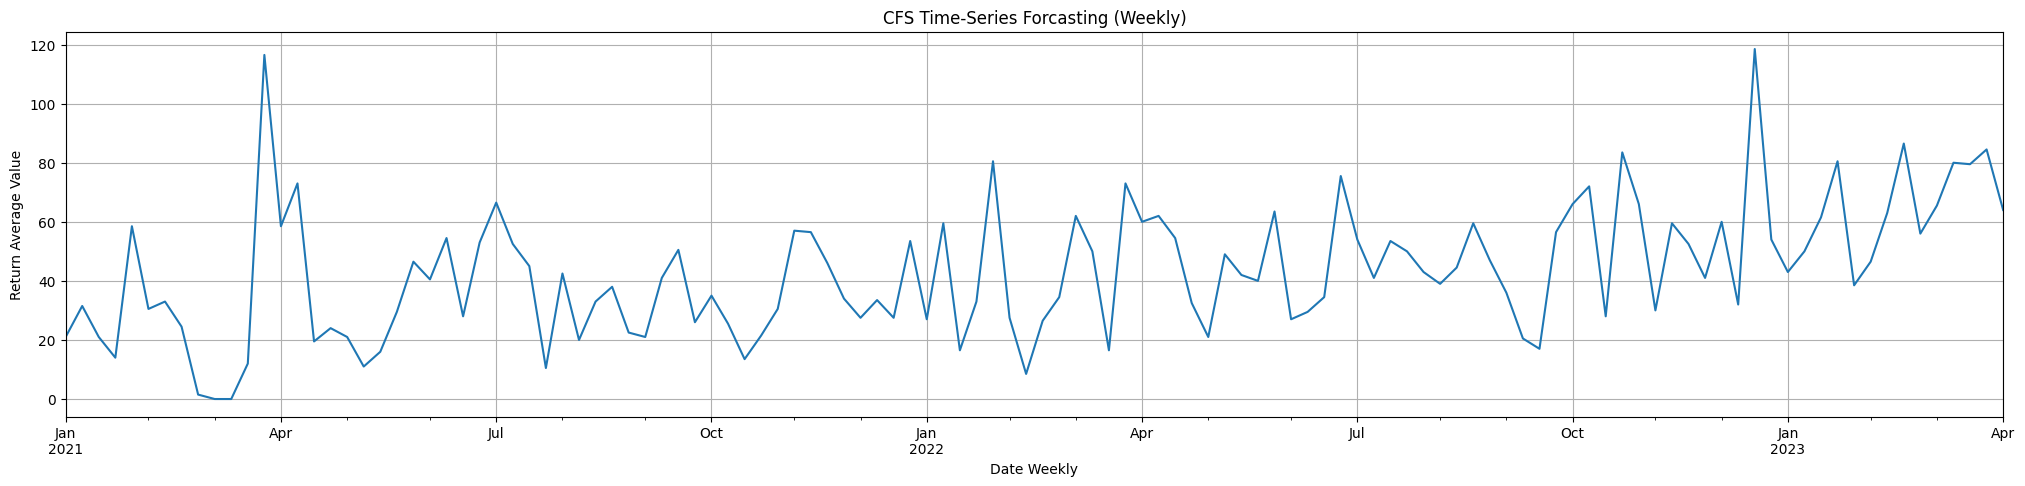

In [22]:
#Plotting the data Weekly
data['CFS'].groupby(pd.Grouper(freq="W")).median().plot(figsize=(25,5),
                                                      title= 'CFS Time-Series Forcasting (Weekly)',
                                                      xlabel= 'Date Weekly',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

<Axes: title={'center': 'CFS Time-Series Forcasting (Monthly)'}, xlabel='Date Monthly', ylabel='Return Average Value'>

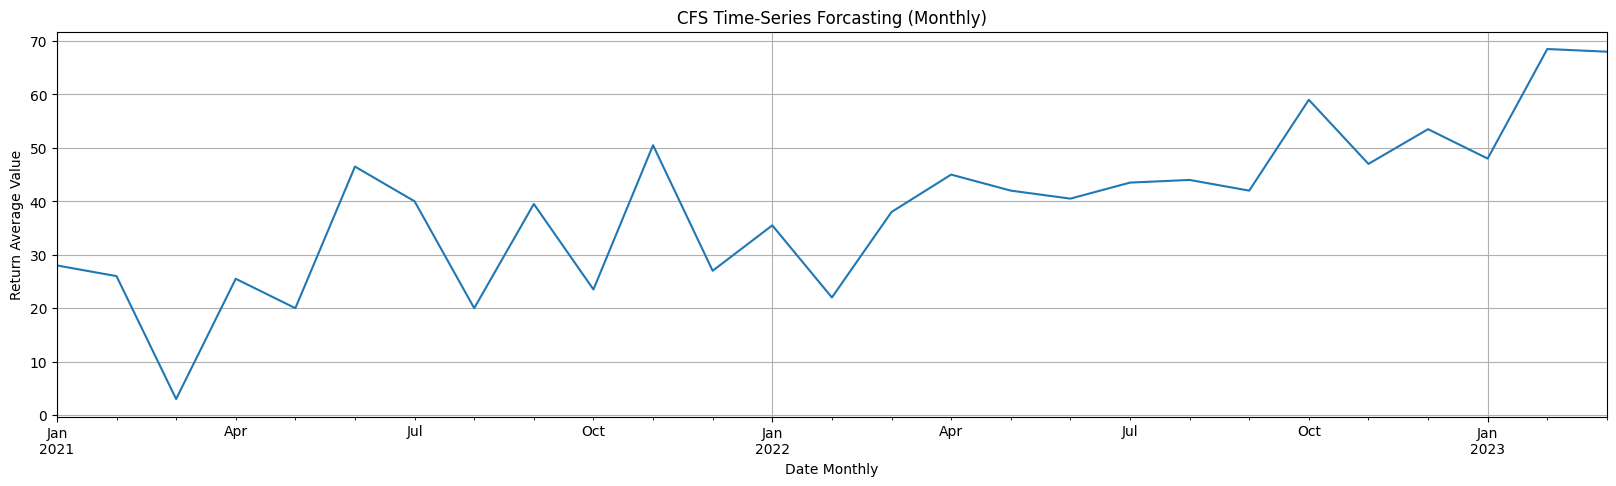

In [23]:
#Plotting the data Monthly
data['CFS'].groupby(pd.Grouper(freq="ME")).median().plot(figsize=(20,5),
                                                      title= 'CFS Time-Series Forcasting (Monthly)',
                                                      xlabel= 'Date Monthly',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

### **Column: CFS Initial Conclusion**

- The column has a **strong positive trend**, That indicates that the number of returns is and has been increasing by time, This can be seen from both graphs however it is more visible in the monthly frequency graph.
- The column has irregular peaks and troughs which means the column is cyclical (Its peaks and troughs are unpredictable)



---

Column: **PBFS**

<Axes: title={'center': 'PBFS Time-Series Forcasting (Weekly)'}, xlabel='Date Weekly', ylabel='Return Average Value'>

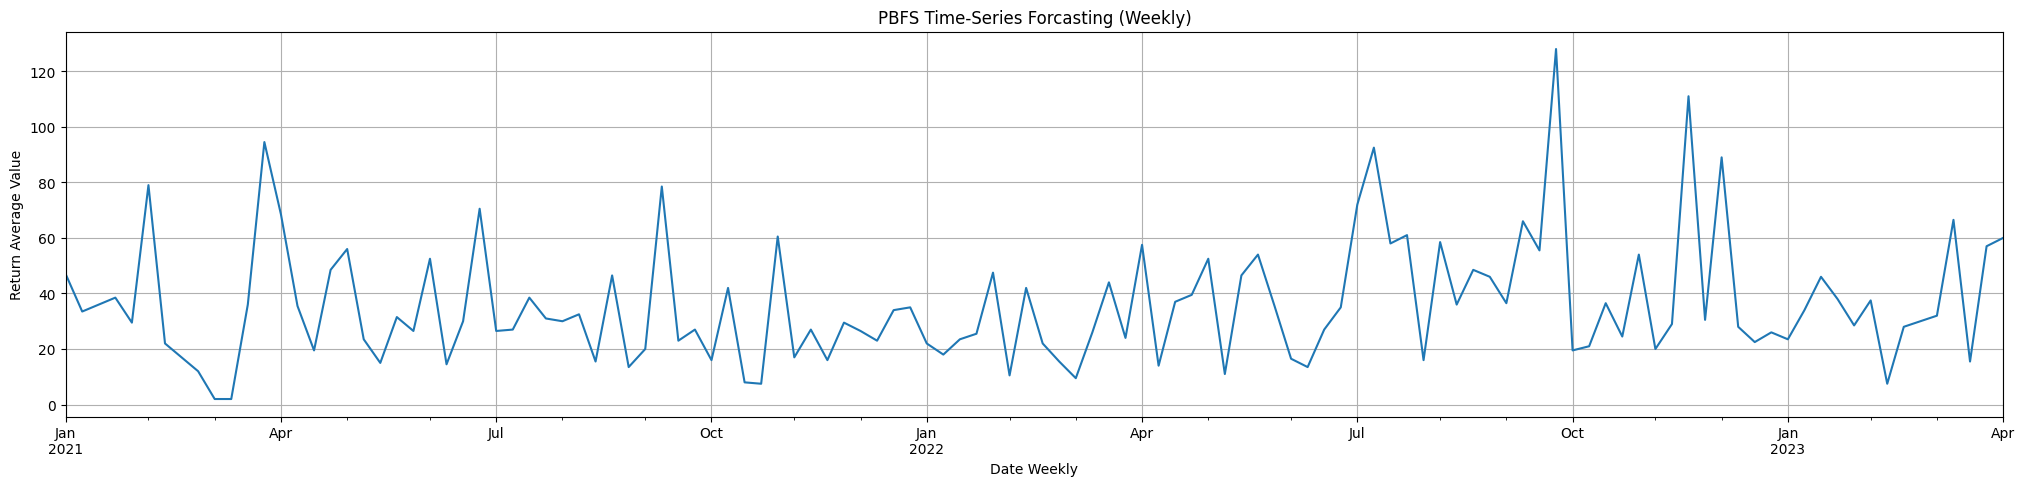

In [24]:
#Plotting the data Weekly
data['PBFS'].groupby(pd.Grouper(freq="W")).median().plot(figsize=(25,5),
                                                      title= 'PBFS Time-Series Forcasting (Weekly)',
                                                      xlabel= 'Date Weekly',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

<Axes: title={'center': 'PBFS Time-Series Forcasting (Monthly)'}, xlabel='Date Monthly', ylabel='Return Average Value'>

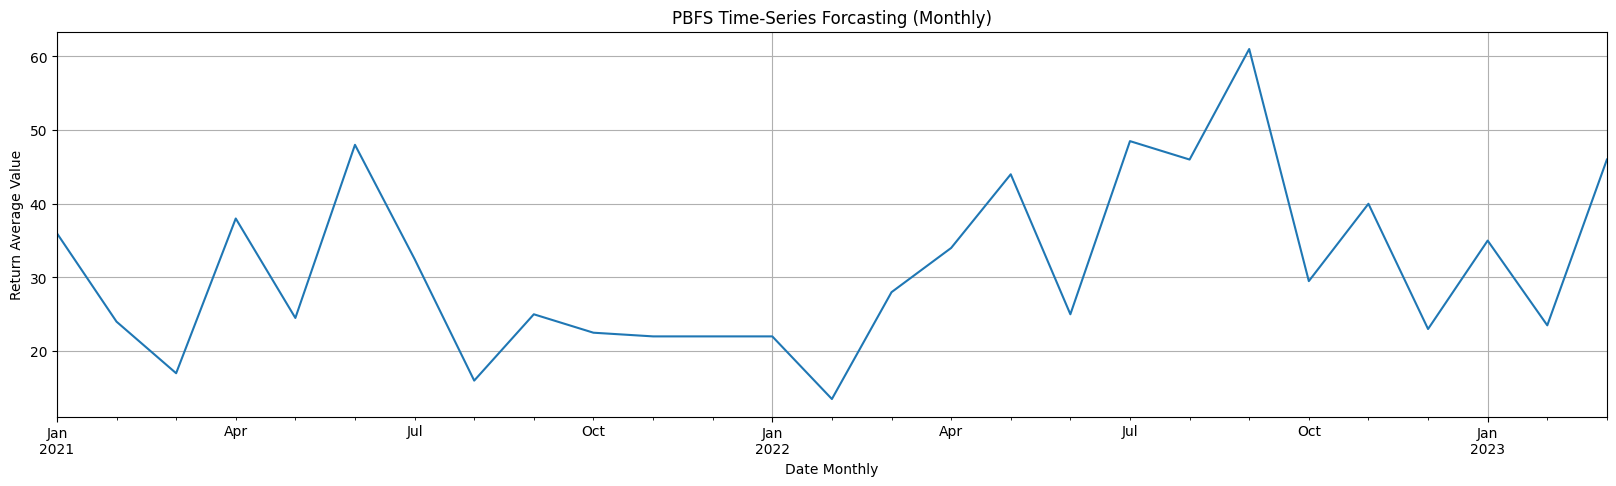

In [25]:
#Plotting the data Monthly
data['PBFS'].groupby(pd.Grouper(freq="ME")).median().plot(figsize=(20,5),
                                                      title= 'PBFS Time-Series Forcasting (Monthly)',
                                                      xlabel= 'Date Monthly',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

<Axes: title={'center': 'PBFS Time-Series Forcasting (Per Quarter)'}, xlabel='Date (Per Quarter)', ylabel='Return Average Value'>

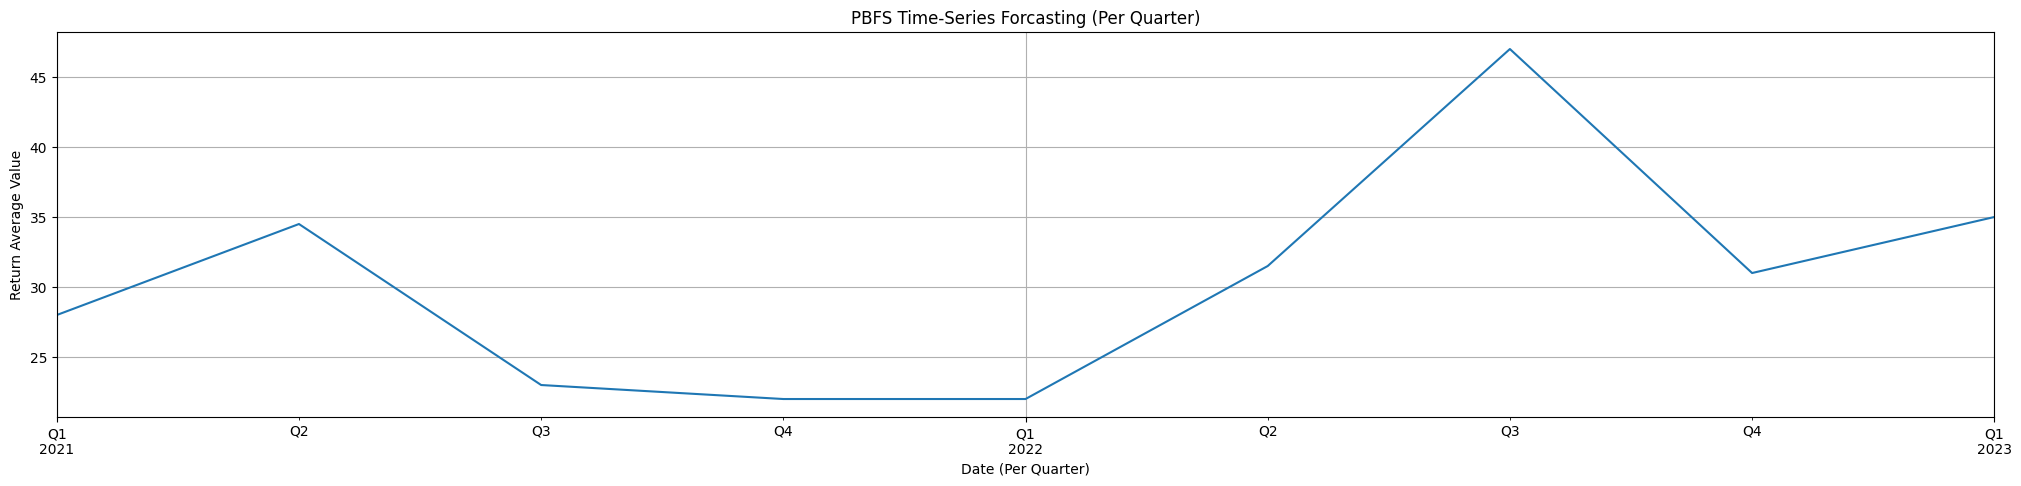

In [26]:
#Plotting the data Per Quarter
data['PBFS'].groupby(pd.Grouper(freq="QE")).median().plot(figsize=(25,5),
                                                      title= 'PBFS Time-Series Forcasting (Per Quarter)',
                                                      xlabel= 'Date (Per Quarter)',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

### **Column: PBFS Initial Conclusion**

- The column has a **slight positive trend**, That indicates that the number of returns is and has been increasing slightly by time, This is hard to validate from a weekly or monthly perspective, However on a querterly basis it can be noticed.
- The column has irregular peaks and troughs which means the column is cyclical (Its peaks and troughs are unpredictable)



---

Column: **VFR**

<Axes: title={'center': 'VFR Time-Series Forcasting (Weekly)'}, xlabel='Date Weekly', ylabel='Return Average Value'>

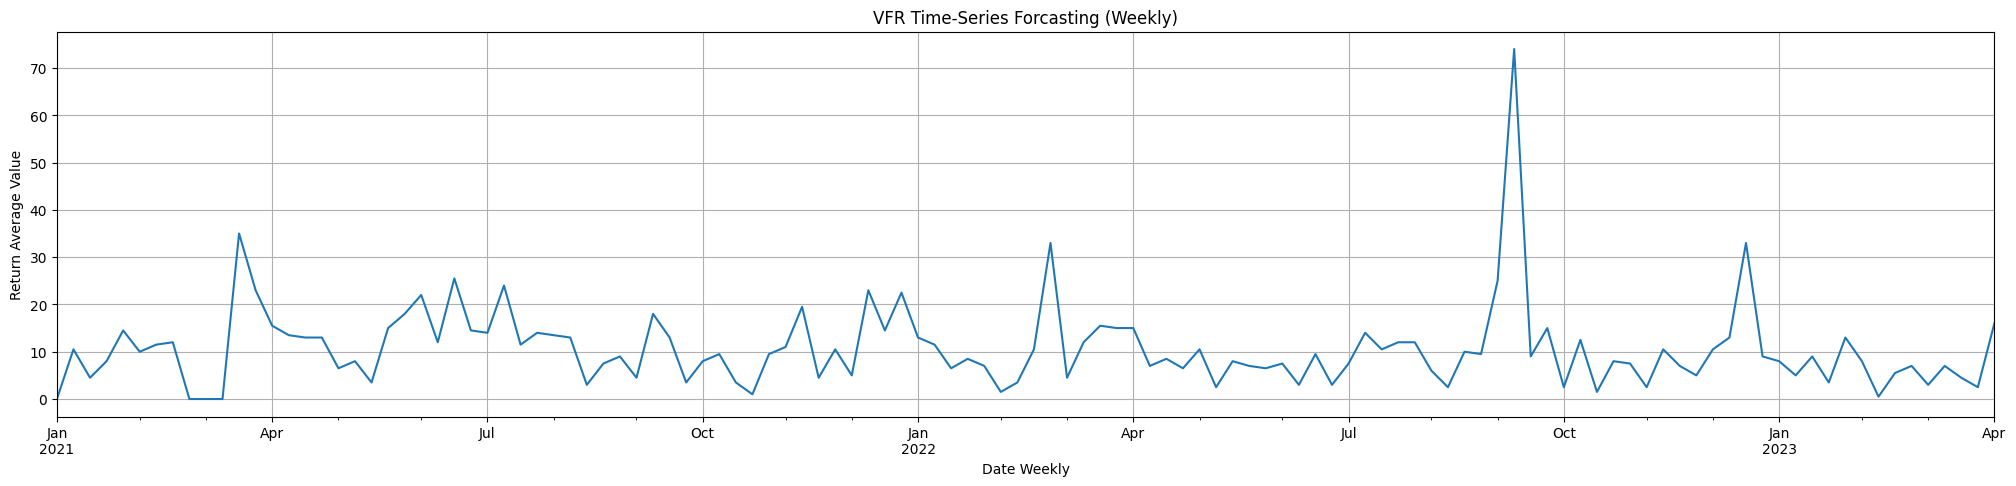

In [27]:
#Plotting the data Weekly
data['VFR'].groupby(pd.Grouper(freq="W")).median().plot(figsize=(25,5),
                                                      title= 'VFR Time-Series Forcasting (Weekly)',
                                                      xlabel= 'Date Weekly',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

<Axes: title={'center': 'VFR Time-Series Forcasting (Monthly)'}, xlabel='Date Monthly', ylabel='Return Average Value'>

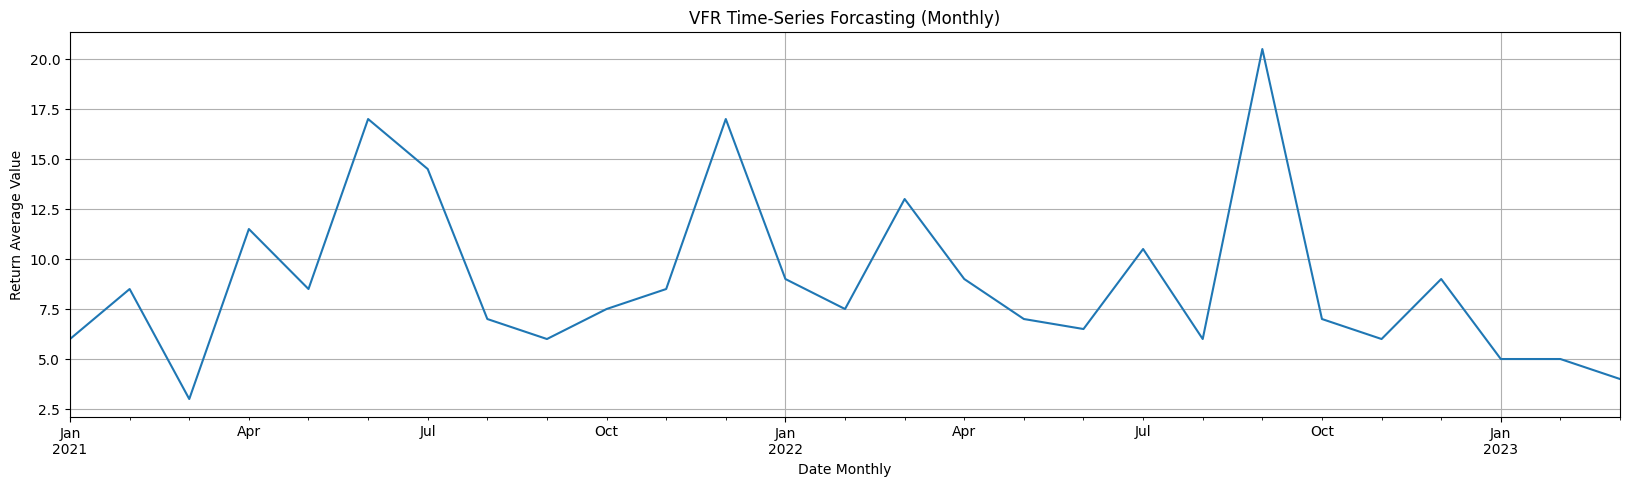

In [28]:
#Plotting the data Monthly
data['VFR'].groupby(pd.Grouper(freq="ME")).median().plot(figsize=(20,5),
                                                      title= 'VFR Time-Series Forcasting (Monthly)',
                                                      xlabel= 'Date Monthly',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

<Axes: title={'center': 'VFR Time-Series Forcasting (Per Quarter)'}, xlabel='Date (Per Quarter)', ylabel='Return Average Value'>

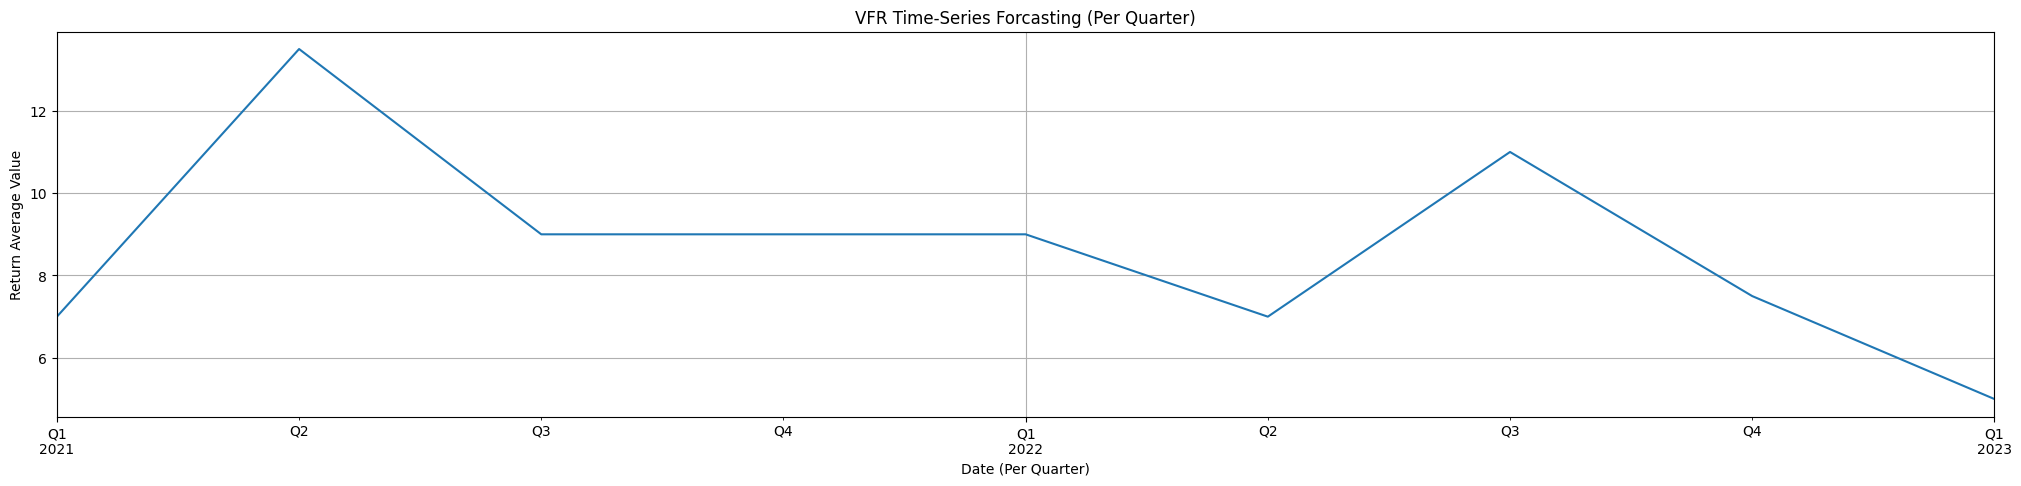

In [29]:
#Plotting the data Per Quarter
data['VFR'].groupby(pd.Grouper(freq="QE")).median().plot(figsize=(25,5),
                                                      title= 'VFR Time-Series Forcasting (Per Quarter)',
                                                      xlabel= 'Date (Per Quarter)',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

### **Column: VFR Initial Conclusion**

- The column has a **negative trend**, That indicates that the number of returns is and has been decreasing by time, This can be clearly seen in the Quarterly graph.
- The column has irregular peaks and troughs which means the column is cyclical (Its peaks and troughs are unpredictable)



---


### **CFS, PBFS and VFR Comparison**

<Axes: title={'center': 'Feature Comparison - Time-Series Forcasting (Per Quarter)'}, xlabel='Date (Per Quarter)', ylabel='Return Average Value'>

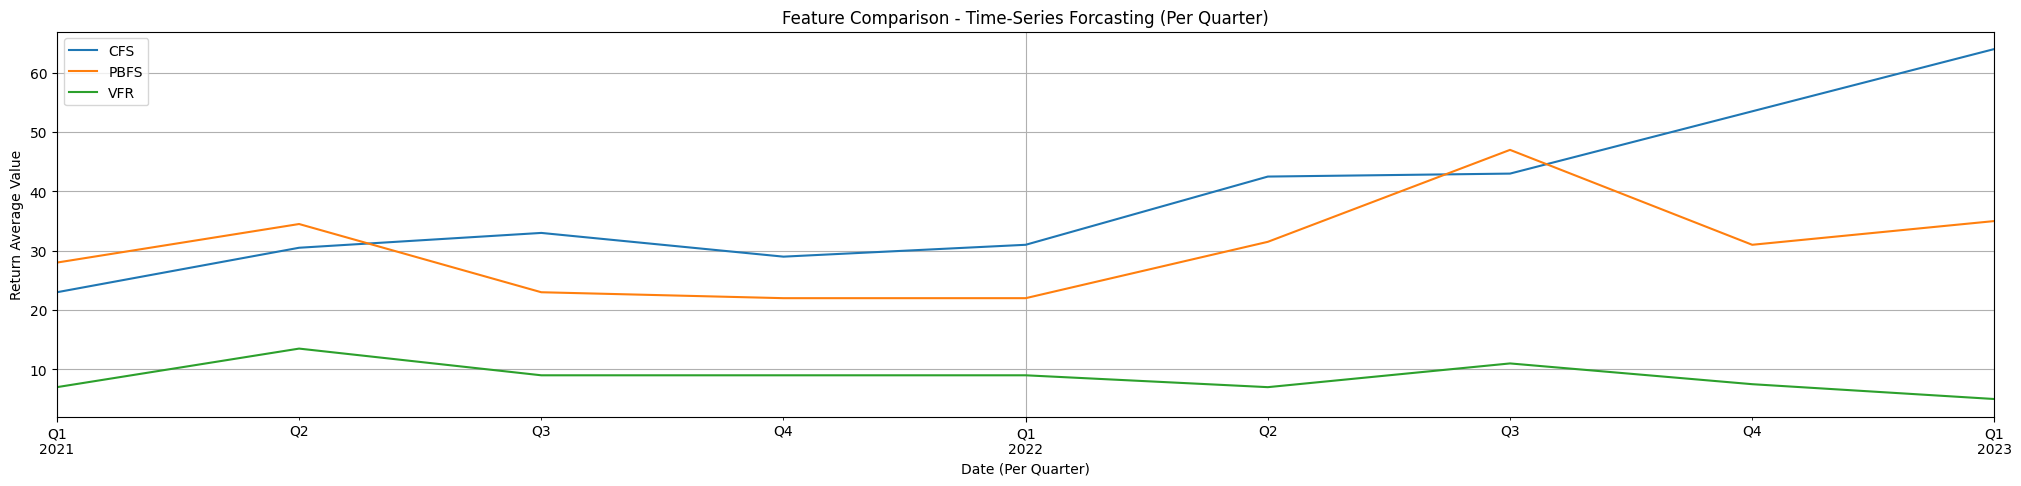

In [30]:
#Plotting the data Weekly
data.groupby(pd.Grouper(freq="QE")).median(numeric_only=True).plot(figsize=(25,5),
                                                      title= 'Feature Comparison - Time-Series Forcasting (Per Quarter)',
                                                      xlabel= 'Date (Per Quarter)',
                                                      ylabel= 'Return Average Value',
                                                      grid=True)

### **CFS, PBFS and VFR Comparison Conclusion**

- Despite a similar peaks and troughs between `CFS` and `PBFS` from Jan 2021 to Aug 2021 yet that variation doesn't hold up to the rest of the intervals, Hence, This confirms that the data is Cyclical.



---


### **Final Conclusion**

- Both `CFS` and `PBFS` line of products have an upward trend of returns while `VFR` line of products has a downward trend of returns.
- That is not formulated upon seasonality (regular peak and troughs) it is based on irregular peaks and troughs, Meaning, Peaks and Troughs in the 3 columns are due to irregular and inconsistenent events.


---



## **ML Modeling:** Model Diagnostics

Since the data has a Cyclic variation (it doesn't follow a regular identifiable/predictable peaks and troughs) we may assume that the data consists of white noise, Hence, To choose the right model, We have to either confirm or eliminate the White Noise assumption.

**White Noise means that the data has:**
- A constant Mean.
- A constant Standard Deviation.
- A correlation between points of Zero.

**Note: All 3 requirements above has to be met to consider the data `White Noise` If the data is `White Noise` then we can't accurately predict the values, That's because in this case the data is**  ***random***

(-50.0, 250.0)

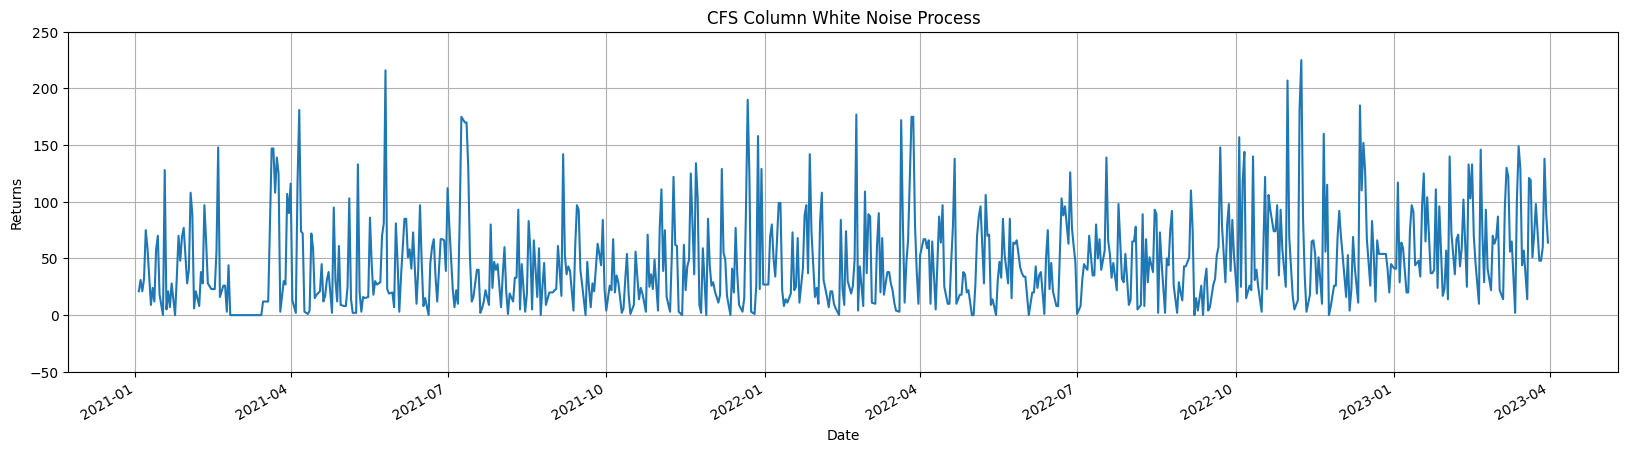

In [31]:
#Plotting CFS column
data['CFS'].plot(figsize=(20,5), title= 'CFS Column White Noise Process',
                 xlabel= 'Date',
                 ylabel= 'Returns',
                 grid=True)
plt.ylim(-50,250)

**We can notice that this column doesn't meet the requirements of white noise, Primirally because of the high variability in the data**

(-50.0, 250.0)

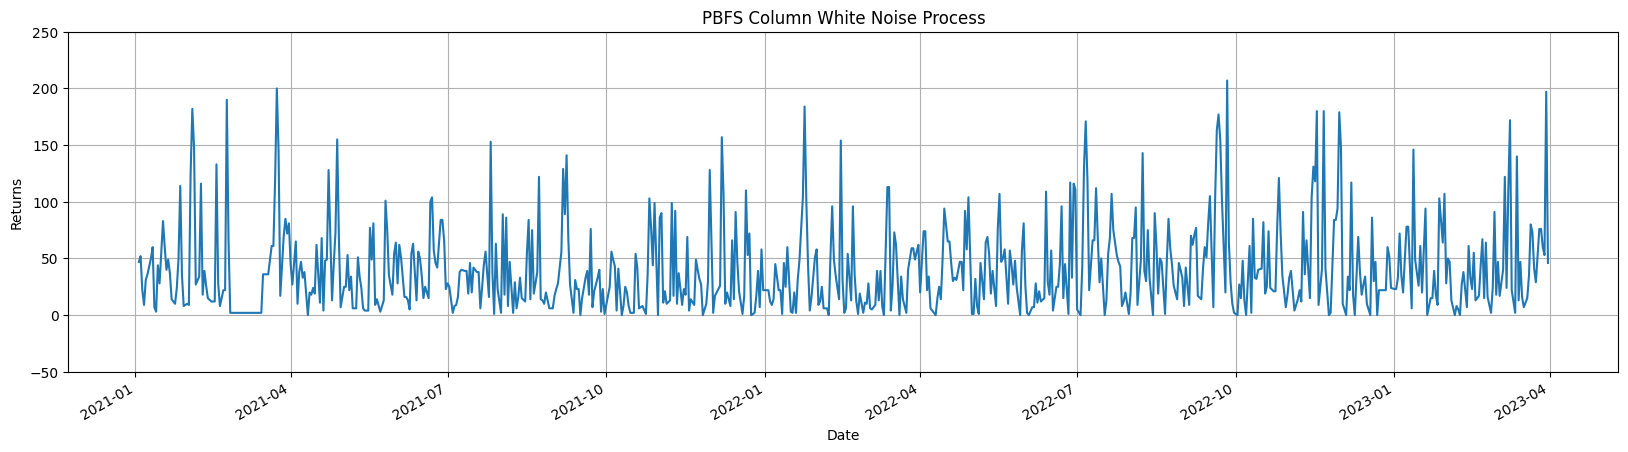

In [32]:
#Plotting PBFS column
data['PBFS'].plot(figsize=(20,5), title= 'PBFS Column White Noise Process',
                 xlabel= 'Date',
                 ylabel= 'Returns',
                 grid=True)
plt.ylim(-50,250)


**The same observation can be noticed in `PBFS` column as well  
Hence, This column is also not White Noise.**

(-50.0, 250.0)

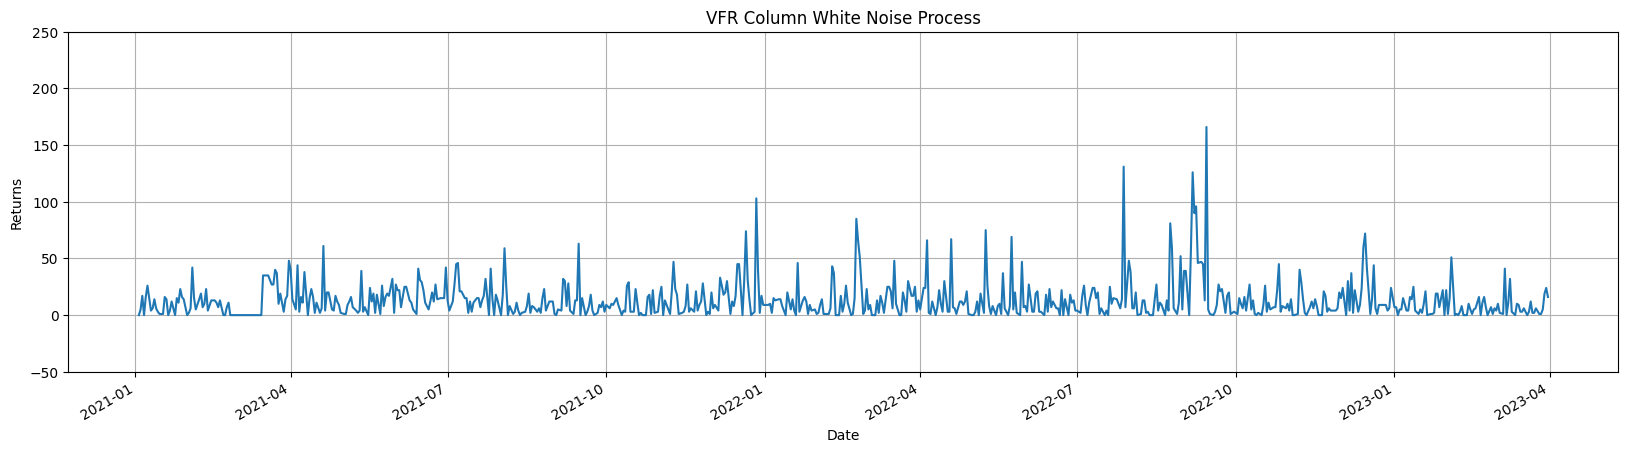

In [33]:
#Plotting VFR column
data['VFR'].plot(figsize=(20,5), title= 'VFR Column White Noise Process',
                 xlabel= 'Date',
                 ylabel= 'Returns',
                 grid=True)
plt.ylim(-50,250)

**At first, It might seem that it is hard to tell,  However, Segregating the graph into 3 parts, We can notice a low variability at first part of the graph (on the left) then a higher variability (in the middle) then a higher variability (at the beginning of 3rd part on the right of the graph), Moreover, we can argue that it satisfies the mean condition but as long as it violates the variability condition then it is not a white noise data**



---

### **Further Model Diagnostics**
Figuring out the stationarity of the data

**Stationery** is kinda similar to White Noise because it also has some requirements that are kinda similar to white noise, Which are:

- Constant Mean
- Constant Standard Deviation
- There's no Seasonality

**Note:** We have already plotted the data above and we can confirm that it violates the 2nd condition however, We can run further analysis to confirm whether the data is stationery or non-stationery.

#### **Dicky-Fuller Test (Hypothesis Testing)**
The Dicky-Fuller test assumes that the data is non-stationery while the alternative assumes that it is stationery.

We will find the t-statistics and compare it with the critical value and if it is smaller then we reject the null hypothesis and vice versa.

**Note: Knowing the stationarity of the data is important for picking the right ML model**

In [34]:
#Dicky-Fuller Test | Column: CFS
sts.adfuller(data['CFS'])

(-8.11954632792459,
 1.1660691182577663e-12,
 5,
 696,
 {'1%': -3.4397804336105198,
  '5%': -2.865701589065464,
  '10%': -2.5689861435625576},
 6947.647560430813)

#### **Interpreting the outcome**

t-statistic value: **-8.1195**

critical value 1%: **-3.4397**

critical value 5%: **-2.8657**

critical value 10%: **-2.5689**

We can notice that the t-statistic value is lower than any of the ciritcal values, Hence, This column is **Stationery**

In [35]:
#Dicky-Fuller Test | Column: PBFS
sts.adfuller(data['PBFS'])

(-6.2284450855269755,
 5.021461379119719e-08,
 18,
 683,
 {'1%': -3.439960610754265,
  '5%': -2.8657809735786244,
  '10%': -2.5690284373908066},
 6871.925580169082)

#### **Interpreting the outcome**

t-statistic value: **-6.2284**

critical value 1%: **-3.4399**

critical value 5%: **-2.8657**

critical value 10%: **-2.5690**

We can notice that the t-statistic value is lower than any of the ciritcal values, Hence, This column is **Stationery**

In [36]:
#Dicky-Fuller Test | Column: VFR
sts.adfuller(data['VFR'])

(-7.489861595555994,
 4.535549352881587e-11,
 5,
 696,
 {'1%': -3.4397804336105198,
  '5%': -2.865701589065464,
  '10%': -2.5689861435625576},
 5774.6704827222775)

#### **Interpreting the outcome**

t-statistic value: **-7.4898**

critical value 1%: **-3.4397**

critical value 5%: **-2.8657**

critical value 10%: **-2.5689**

We can notice that the t-statistic value is lower than any of the ciritcal values, Hence, This column is **Stationery**



---

### **Model Diagnostic Conclusion:**

- None of the data is white noise
- All features are Stationery.
- Features are univariate, This means each product line is not affected by the other.

**Note:** With these important information, We can pick a suitable ML Model.



---

## **Prophet Modeling:** Splitting the data into 3 separate dataframes

In [37]:
data.reset_index(inplace=True)
data_CFS = data[['date','CFS']]
data_PBFS = data[['date','PBFS']]
data_VFR = data[['date','VFR']]

**NOTE:** Prophet model requires the date column to be called `ds` and the value column to be called `y`, Hence, Columns have to be renamed.

In [38]:
data_CFS.rename({'date':'ds',
                 'CFS':'y'}, axis=1, inplace=True)

data_PBFS.rename({'date':'ds',
                 'PBFS':'y'}, axis=1, inplace=True)

data_VFR.rename({'date':'ds',
                 'VFR':'y'}, axis=1, inplace=True)

<ipython-input-38-3ed3ae7f8995>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_CFS.rename({'date':'ds',
<ipython-input-38-3ed3ae7f8995>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_PBFS.rename({'date':'ds',
<ipython-input-38-3ed3ae7f8995>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_VFR.rename({'date':'ds',




---


## **Modeling: Forecasting 365 days**
**Predicting Product Line:** CFS

In [39]:
#Initiating the model and fitting the data
model = Prophet()
model.fit(data_CFS)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/1z5aakbv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/zvxg66wu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76681', 'data', 'file=/tmp/tmpz5lj3_ih/1z5aakbv.json', 'init=/tmp/tmpz5lj3_ih/zvxg66wu.json', 'output', 'file=/tmp/tmpz5lj3_ih/prophet_modelzoj5onxj/prophet_model-20250221190244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [40]:
#Predicting/Forecasting the number of returns over the upcoming 365 days
predict_CFS = model.make_future_dataframe(periods=365, freq='d')
predict_CFS = model.predict(predict_CFS)
predict_CFS['yhat'] = np.where(predict_CFS['yhat'] <= 0, 0, predict_CFS['yhat']) #Eliminating any possible negative predictions

In [41]:
predict_CFS.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1062,2024-03-26,75.424035,69.146424,159.783348,75.349327,75.503665,39.459722,39.459722,39.459722,13.366626,13.366626,13.366626,26.093095,26.093095,26.093095,0.0,0.0,0.0,114.883757
1063,2024-03-27,75.460788,63.101752,155.620983,75.385601,75.540657,34.473548,34.473548,34.473548,7.313599,7.313599,7.313599,27.159948,27.159948,27.159948,0.0,0.0,0.0,109.934335
1064,2024-03-28,75.497541,56.393617,153.697712,75.421875,75.577650,32.137647,32.137647,32.137647,4.235567,4.235567,4.235567,27.902081,27.902081,27.902081,0.0,0.0,0.0,107.635188
1065,2024-03-29,75.534294,44.097671,139.264541,75.458149,75.614600,17.626831,17.626831,17.626831,-10.678249,-10.678249,-10.678249,28.305081,28.305081,28.305081,0.0,0.0,0.0,93.161125
1066,2024-03-30,75.571046,50.578627,146.381680,75.494423,75.651703,22.390330,22.390330,22.390330,-5.970404,-5.970404,-5.970404,28.360734,28.360734,28.360734,0.0,0.0,0.0,97.961377


In [42]:
#Extracting only the concerned columns
predict_CFS[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1062,2024-03-26,114.883757,69.146424,159.783348
1063,2024-03-27,109.934335,63.101752,155.620983
1064,2024-03-28,107.635188,56.393617,153.697712
1065,2024-03-29,93.161125,44.097671,139.264541
1066,2024-03-30,97.961377,50.578627,146.381680


### **Note:** The model created many columns however what we should be interested in is `yhat` this is the predicted value, However, We must note that the model also provides a confidence interval (lower value and upper value) this gives a good approximation to the `yhat`.

In [43]:
plot_plotly(model, predict_CFS)

In [44]:
plot_components_plotly(model, predict_CFS)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



### **Product Line: CFS Model Prediction Conclusion**
The model has predicted:
- The number of returns will keep on **increasing** through out the year of 2024.
- On daily basis the model predicted that the number of returns **increases** in `mid-week (Monday to Thursday)` yet it **decreases** by the `end and start of the week (Friday to Sat)`
- On a monthly basis, The number of returns would be **increased** in `March`, `April`, `July` and `mid-November`, yet it **decreases** by `May`, `Aug` and `Sep`.



---
### **Predicting Product Line:** PBFS


In [45]:
#Initiating the model and fitting the data
model = Prophet()
model.fit(data_PBFS)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/2_i_ahra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/2n6e3rgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80788', 'data', 'file=/tmp/tmpz5lj3_ih/2_i_ahra.json', 'init=/tmp/tmpz5lj3_ih/2n6e3rgt.json', 'output', 'file=/tmp/tmpz5lj3_ih/prophet_modelx6e5trgg/prophet_model-20250221190246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [46]:
#Predicting/Forecasting the number of returns over the upcoming 365 days
predict_PBFS = model.make_future_dataframe(periods=365, freq='d')
predict_PBFS = model.predict(predict_PBFS)
predict_PBFS['yhat'] = np.where(predict_PBFS['yhat'] <= 0, 0, predict_PBFS['yhat']) #Eliminating any possible negative predictions

In [47]:
predict_PBFS.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1062,2024-03-26,58.698060,30.980399,122.064808,57.612625,59.796350,18.310249,18.310249,18.310249,4.779335,4.779335,4.779335,13.530914,13.530914,13.530914,0.0,0.0,0.0,77.008309
1063,2024-03-27,58.721249,35.552971,126.664018,57.635281,59.824724,22.552980,22.552980,22.552980,9.150993,9.150993,9.150993,13.401986,13.401986,13.401986,0.0,0.0,0.0,81.274228
1064,2024-03-28,58.744438,28.121904,120.127742,57.658142,59.852942,14.070910,14.070910,14.070910,0.983331,0.983331,0.983331,13.087579,13.087579,13.087579,0.0,0.0,0.0,72.815348
1065,2024-03-29,58.767627,7.655266,104.677277,57.681040,59.881076,-0.415937,-0.415937,-0.415937,-13.020973,-13.020973,-13.020973,12.605037,12.605037,12.605037,0.0,0.0,0.0,58.351690
1066,2024-03-30,58.790816,29.587043,117.673868,57.702670,59.908060,16.091387,16.091387,16.091387,4.116863,4.116863,4.116863,11.974524,11.974524,11.974524,0.0,0.0,0.0,74.882203


In [48]:
#Extracting only the concerned columns
predict_CFS[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1062,2024-03-26,114.883757,69.146424,159.783348
1063,2024-03-27,109.934335,63.101752,155.620983
1064,2024-03-28,107.635188,56.393617,153.697712
1065,2024-03-29,93.161125,44.097671,139.264541
1066,2024-03-30,97.961377,50.578627,146.381680


In [49]:
plot_plotly(model, predict_PBFS)

In [50]:
plot_components_plotly(model, predict_PBFS)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



### **Product Line: PBFS Model Prediction Conclusion**
The model has predicted:
- The number of returns will keep on **increasing** through out the year of 2024.
- On monthly basis, There are inconsistencies in the volume of returned products, The model is predicting a **downfall** in volume around `March` and `Mid Oct` while it also predicts **high peaks** in volume in `Mid Sep and early Oct`, `July` and `April`.
- On daily basis, The model predicts some sort of the same behavior on daily basis as product line: CFS, an **Increase** in volume by `mid-week (Monday to Thursday)`.



---
### **Predicting Product Line:** VFR


In [51]:
#Initiating the model and fitting the data
model = Prophet()
model.fit(data_VFR)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/wpl1tw_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/uhggcgv7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9494', 'data', 'file=/tmp/tmpz5lj3_ih/wpl1tw_5.json', 'init=/tmp/tmpz5lj3_ih/uhggcgv7.json', 'output', 'file=/tmp/tmpz5lj3_ih/prophet_model63rdkhjp/prophet_model-20250221190248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [52]:
#Predicting/Forecasting the number of returns over the upcoming 365 days
predict_VFR = model.make_future_dataframe(periods=365, freq='d')
predict_VFR = model.predict(predict_VFR)
predict_VFR['yhat'] = np.where(predict_VFR['yhat'] <= 0, 0, predict_VFR['yhat']) #Eliminating any possible negative predictions

In [53]:
predict_VFR.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1062,2024-03-26,4.288538,-9.509585,31.955505,3.311477,5.270928,7.407228,7.407228,7.407228,4.678987,4.678987,4.678987,2.728241,2.728241,2.728241,0.0,0.0,0.0,11.695765
1063,2024-03-27,4.271530,-6.818862,33.153592,3.291597,5.257146,7.837200,7.837200,7.837200,4.606184,4.606184,4.606184,3.231016,3.231016,3.231016,0.0,0.0,0.0,12.108730
1064,2024-03-28,4.254522,-7.732043,30.292786,3.272139,5.245766,6.589630,6.589630,6.589630,2.874046,2.874046,2.874046,3.715584,3.715584,3.715584,0.0,0.0,0.0,10.844151
1065,2024-03-29,4.237514,-13.478355,27.824615,3.252814,5.234397,2.723564,2.723564,2.723564,-1.448617,-1.448617,-1.448617,4.172181,4.172181,4.172181,0.0,0.0,0.0,6.961078
1066,2024-03-30,4.220506,-16.427446,22.073461,3.233942,5.223029,-1.427689,-1.427689,-1.427689,-6.018650,-6.018650,-6.018650,4.590961,4.590961,4.590961,0.0,0.0,0.0,2.792817


In [54]:
#Extracting only the concerned columns
predict_VFR[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1062,2024-03-26,11.695765,-9.509585,31.955505
1063,2024-03-27,12.108730,-6.818862,33.153592
1064,2024-03-28,10.844151,-7.732043,30.292786
1065,2024-03-29,6.961078,-13.478355,27.824615
1066,2024-03-30,2.792817,-16.427446,22.073461


In [55]:
plot_plotly(model, predict_VFR)

In [56]:
plot_components_plotly(model, predict_VFR)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



### **Product Line: VFR Model Prediction Conclusion**
The model has predicted:
- The number of returns is relatively low and is **decreasing** to almost zero by the end of 2024.
- On monthly basis, The model predicted stability throughout the year yet it is expecting a **high jump** during `September`.
- On Daily basis, The model still predicts a high volume of returns during mid-week and a low volume by the end and beginning of the week, Yet, Still the volume of increase way less than `CFS` and `PBFS` product line.

###**Finally,** The model confirms on the insights extracted at the initial time-series analysis at the beginning of the project.
- An upward trend on `CFS` and `PBFS` product lines.
- A downward trend on `VFR` product line.
- The 3 features have irregular peaks and troughs (cyclical variation).
- `VFR` product line is performing better in terms of low volume in return in comparison with `CFS` and `PBFS` product lines.



---

## **Model Evaluation**
### **Splitting each dataset at a cut off point** `2023-01-31`

In [57]:
split_date = '2023-01-31'
#CFS Column
CFS_train = data_CFS.loc[data_CFS['ds'] <= split_date].copy()
CFS_test = data_CFS.loc[data_CFS['ds'] > split_date].copy()

#PBFS Column
PBFS_train = data_PBFS.loc[data_PBFS['ds'] <= split_date].copy()
PBFS_test = data_PBFS.loc[data_PBFS['ds'] > split_date].copy()

#VFR Column
VFR_train = data_VFR.loc[data_VFR['ds'] <= split_date].copy()
VFR_test = data_VFR.loc[data_VFR['ds'] > split_date].copy()



---

## **Model Evaluation:** Prediction VS Test Data
### **Predicting Product Line:** CFS

In [58]:
#Initiating the model and fitting the data
CFS_model = Prophet()
CFS_model.fit(CFS_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/fivm4bxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/r4otng6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32714', 'data', 'file=/tmp/tmpz5lj3_ih/fivm4bxv.json', 'init=/tmp/tmpz5lj3_ih/r4otng6g.json', 'output', 'file=/tmp/tmpz5lj3_ih/prophet_model2raaxm8y/prophet_model-20250221190249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [59]:
#Predicting/Forecasting
predict_CFS = CFS_model.make_future_dataframe(periods=365, freq='d')
predict_CFS = CFS_model.predict(CFS_test)
predict_CFS['yhat'] = np.where(predict_CFS['yhat'] <= 0, 0, predict_CFS['yhat']) #Eliminating any possible negative predictions

In [60]:
predict_CFS.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
46,2023-03-27,57.254220,54.008513,147.739310,57.254197,57.254250,42.967992,42.967992,42.967992,15.146663,15.146663,15.146663,27.821330,27.821330,27.821330,0.0,0.0,0.0,100.222213
47,2023-03-28,57.281125,51.749629,141.490229,57.281101,57.281156,42.125415,42.125415,42.125415,12.854622,12.854622,12.854622,29.270793,29.270793,29.270793,0.0,0.0,0.0,99.406540
48,2023-03-29,57.308030,47.281717,141.815916,57.308005,57.308062,37.680594,37.680594,37.680594,7.357091,7.357091,7.357091,30.323503,30.323503,30.323503,0.0,0.0,0.0,94.988624
49,2023-03-30,57.334934,43.695775,136.821648,57.334908,57.334968,35.200558,35.200558,35.200558,4.238143,4.238143,4.238143,30.962415,30.962415,30.962415,0.0,0.0,0.0,92.535492
50,2023-03-31,57.361839,30.369143,127.765910,57.361812,57.361873,20.614477,20.614477,20.614477,-10.563694,-10.563694,-10.563694,31.178171,31.178171,31.178171,0.0,0.0,0.0,77.976316


In [61]:
#Extracting only the concerned columns
predict_CFS[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
46,2023-03-27,100.222213,54.008513,147.739310
47,2023-03-28,99.406540,51.749629,141.490229
48,2023-03-29,94.988624,47.281717,141.815916
49,2023-03-30,92.535492,43.695775,136.821648
50,2023-03-31,77.976316,30.369143,127.765910


In [62]:
#Plotting CFS Prediction
plot_plotly(CFS_model, predict_CFS)

In [63]:
#Plotting CFS Prediction
plot_components_plotly(CFS_model, predict_CFS)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.





---
### **Predicting Product Line:** PBFS


In [64]:
#Initiating the model and fitting the data
PBFS_model = Prophet()
PBFS_model.fit(PBFS_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/x5moorhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/u9m94_a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61702', 'data', 'file=/tmp/tmpz5lj3_ih/x5moorhu.json', 'init=/tmp/tmpz5lj3_ih/u9m94_a4.json', 'output', 'file=/tmp/tmpz5lj3_ih/prophet_modelc99cp33f/prophet_model-20250221190250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [65]:
#Predicting/Forecasting
predict_PBFS = PBFS_model.make_future_dataframe(periods=365, freq='d')
predict_PBFS = PBFS_model.predict(PBFS_test)
predict_PBFS['yhat'] = np.where(predict_PBFS['yhat'] <= 0, 0, predict_PBFS['yhat']) #Eliminating any possible negative predictions

In [66]:
predict_PBFS.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
46,2023-03-27,51.958505,35.961289,125.484623,51.854373,52.056606,27.067641,27.067641,27.067641,12.451176,12.451176,12.451176,14.616465,14.616465,14.616465,0.0,0.0,0.0,79.026146
47,2023-03-28,51.987139,24.417494,116.762760,51.878927,52.090464,19.358349,19.358349,19.358349,5.107839,5.107839,5.107839,14.250509,14.250509,14.250509,0.0,0.0,0.0,71.345488
48,2023-03-29,52.015773,29.330569,120.698370,51.903535,52.123310,23.946674,23.946674,23.946674,10.316275,10.316275,10.316275,13.630399,13.630399,13.630399,0.0,0.0,0.0,75.962447
49,2023-03-30,52.044408,19.538368,108.053182,51.928073,52.154841,11.695671,11.695671,11.695671,-1.090766,-1.090766,-1.090766,12.786437,12.786437,12.786437,0.0,0.0,0.0,63.740079
50,2023-03-31,52.073042,6.809702,94.127538,51.952618,52.185145,-0.190780,-0.190780,-0.190780,-11.943634,-11.943634,-11.943634,11.752854,11.752854,11.752854,0.0,0.0,0.0,51.882263


In [67]:
#Extracting only the concerned columns
predict_PBFS[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
46,2023-03-27,79.026146,35.961289,125.484623
47,2023-03-28,71.345488,24.417494,116.762760
48,2023-03-29,75.962447,29.330569,120.698370
49,2023-03-30,63.740079,19.538368,108.053182
50,2023-03-31,51.882263,6.809702,94.127538


In [68]:
#Plotting PBFS Prediction
plot_plotly(PBFS_model, predict_PBFS)

In [69]:
#Plotting PBFS Prediction
plot_components_plotly(PBFS_model, predict_PBFS)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.





---
### **Predicting Product Line:** VFR


In [70]:
#Initiating the model and fitting the data
VFR_model = Prophet()
VFR_model.fit(VFR_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/8znmgejq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/isvv437w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85146', 'data', 'file=/tmp/tmpz5lj3_ih/8znmgejq.json', 'init=/tmp/tmpz5lj3_ih/isvv437w.json', 'output', 'file=/tmp/tmpz5lj3_ih/prophet_model2zvnf09p/prophet_model-20250221190252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [71]:
#Predicting/Forecasting
predict_VFR = VFR_model.make_future_dataframe(periods=365, freq='d')
predict_VFR = VFR_model.predict(VFR_test)
predict_VFR['yhat'] = np.where(predict_VFR['yhat'] <= 0, 0, predict_VFR['yhat']) #Eliminating any possible negative predictions

In [72]:
predict_VFR.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
46,2023-03-27,14.923690,3.287000,43.731400,14.923687,14.923694,7.967704,7.967704,7.967704,2.222806,2.222806,2.222806,5.744898,5.744898,5.744898,0.0,0.0,0.0,22.891394
47,2023-03-28,14.927589,6.593137,45.252626,14.927585,14.927592,11.147857,11.147857,11.147857,5.017779,5.017779,5.017779,6.130078,6.130078,6.130078,0.0,0.0,0.0,26.075446
48,2023-03-29,14.931487,6.624230,46.624624,14.931483,14.931490,11.464011,11.464011,11.464011,5.000932,5.000932,5.000932,6.463079,6.463079,6.463079,0.0,0.0,0.0,26.395498
49,2023-03-30,14.935385,3.059283,45.500676,14.935381,14.935389,9.438914,9.438914,9.438914,2.701647,2.701647,2.701647,6.737267,6.737267,6.737267,0.0,0.0,0.0,24.374299
50,2023-03-31,14.939283,-1.232963,41.704485,14.939279,14.939287,5.115661,5.115661,5.115661,-1.830915,-1.830915,-1.830915,6.946576,6.946576,6.946576,0.0,0.0,0.0,20.054944


In [73]:
#Extracting only the concerned columns
predict_VFR[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
46,2023-03-27,22.891394,3.287000,43.731400
47,2023-03-28,26.075446,6.593137,45.252626
48,2023-03-29,26.395498,6.624230,46.624624
49,2023-03-30,24.374299,3.059283,45.500676
50,2023-03-31,20.054944,-1.232963,41.704485


In [74]:
#Plotting VFR Prediction
plot_plotly(VFR_model, predict_VFR)

In [75]:
#Plotting VFR Prediction
plot_components_plotly(VFR_model, predict_VFR)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.





---


### **Model Evaluation:** Cross-Validation
The cross validation function is a statistical technique to evaluate ML Models (This is a built-in function in Prophet)

#### **How it works**
1- We split the data at a cut-off point or by 80/20 or 70/30 (there's no best technique)

2- We identify a few parameters:
  - **Initial:** Initial means that the data will train first on a specific number of days
  - **Period:** Period is how much data to be added to training once the initial period is consumed
  - **Horizon:** Horizon is for what period the model should forecast.

In [76]:
#Initiating Cross Validation method
CFS_cv = cross_validation(CFS_model, initial='365 days', period='30 days', horizon = '60 days', parallel='processes')
PBFS_cv = cross_validation(PBFS_model, initial='365 days', period='30 days', horizon = '60 days', parallel='processes')
VFR_cv = cross_validation(VFR_model, initial='365 days', period='30 days', horizon = '60 days', parallel='processes')

INFO:prophet:Making 12 forecasts with cutoffs between 2022-01-06 00:00:00 and 2022-12-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7cb87c123590>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/eoiaz8u0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/mxgzb3n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/gs0cwr8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96126', 'data', 'file=/tmp/tmpz5lj3_ih/mxgzb3n5.json', 'init=/tmp/tmpz5lj3_ih/gs0cwr8u.json', 'output', 'file=/tmp/tmpz5lj3_ih/prophet_modele7epc4f3/prophet_model-20250221190255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5lj3_ih/zgzdvfnw.json
19:02:55 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 0
INFO:cmdstanpy:Chain [

####**Column CFS**

In [77]:
#Creating a performance metrics to measure RMSE
CFS_metrics = performance_metrics(CFS_cv)
CFS_metrics.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,6 days,2029.056896,45.045054,36.958078,0.722904,0.812081,0.708197
1,7 days,1839.538620,42.889843,33.586735,0.636604,0.754042,0.727869
2,8 days,1839.773290,42.892578,33.700166,0.636604,0.762436,0.759016
3,9 days,1686.081604,41.061924,32.013876,0.674401,0.802809,0.774963
4,10 days,1805.800773,42.494715,32.549758,0.674401,0.770182,0.770492


####**Column PBFS**

In [78]:
#Creating a performance metrics to measure RMSE
PBFS_metrics = performance_metrics(PBFS_cv)
PBFS_metrics.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,6 days,1414.293820,37.607098,28.645020,0.692185,0.878107,0.791803
1,7 days,1397.664877,37.385356,29.519439,0.643484,0.878135,0.791803
2,8 days,1363.701501,36.928329,29.072208,0.619553,0.843597,0.788525
3,9 days,1572.389539,39.653367,30.475714,0.608247,0.813878,0.773472
4,10 days,1459.712678,38.206186,29.816799,0.606919,0.792981,0.803279


####**Column VFR**

In [79]:
#Creating a performance metrics to measure RMSE
VFR_metrics = performance_metrics(VFR_cv)
VFR_metrics.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,6 days,590.910775,24.308656,15.702893,0.782243,1.030989,0.757377
1,7 days,570.785874,23.891125,14.876374,0.702352,0.944327,0.790164
2,8 days,553.914082,23.535379,14.697755,0.739332,0.955405,0.775410
3,9 days,360.439010,18.985231,13.449700,0.782243,1.027804,0.773472
4,10 days,288.752887,16.992730,12.449807,0.796724,1.032225,0.786885


### **Evaluation Conclusion:**
**Note:** It is important to bare in mind that model performance is significantly affected by the size of the dataset where the more size the better the result and vice versa.

- Across the 3 product lines, The model has a consistent `RMSE` that indicates that the predications made are proportionate and in an average fit with the actual data, Hence, We can say that the model did a good job predicting the values.

However, It's important to mention that in many cases the lower the `RMSE` the better and that could help evaluate models, where simply the lower the `RMSE` the better.

It would be better to compare the performance of the ML model with another and cross validate.

----------------

##**ML Model:** ARIMA Modeling

**ARIMA** (Autoregressive Integrated Moving Average) is a statistical model commonly used in time-series forecasting. It combines three components - autoregression (AR), differencing (I), and moving average (MA) - to capture the underlying patterns and trends in a time series.

###**Evaluation Parameter: AIC**
**AIC** (Akaike Information Criterion) is a statistical measure used to evaluate the goodness of fit of a model, including ARIMA models. AIC is calculated based on the log-likelihood function of the model and the number of parameters used in the model. The lower the AIC score, the better the model is considered to fit the data. In ARIMA modeling, different models with different combinations of parameters can be compared using their AIC scores to determine the best-fitting model for a given time series data.

In [80]:
data.reset_index(inplace=True)
data_CFS = data[['date','CFS']]
data_PBFS = data[['date','PBFS']]
data_VFR = data[['date','VFR']]

#Taking a copy of the 3 dataframes to use in other models (because prophet model requires column names to be changed) (ARIMA)
arima_CFS = data_CFS.copy()
arima_PBFS = data_PBFS.copy()
arima_VFR = data_VFR.copy()

####**Column:** CFS

In [81]:
CFS_AIC = auto_arima(arima_CFS['CFS'], trace=True)
CFS_AIC.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7485.341, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7388.043, Time=0.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7483.342, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7351.704, Time=1.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7320.593, Time=0.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7271.099, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=7212.999, Time=0.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,1,0)(0,0,0)[0]             : AIC=7211.015, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,1,0)(0,0,0)[0]             : AIC=7269.111, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,1,1)(0,0,0)[0]             : AIC=7162.605, Time=0.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,1,1)(0,0,0)[0]             : AIC=7163.403, Time=0.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,1,2)(0,0,0)[0]             : AIC=7165.932, Time=2.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,1,2)(0,0,0)[0]             : AIC=7164.997, Time=1.65 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 25.061 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  702
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -3574.302
Date:                Fri, 21 Feb 2025   AIC                           7162.605
Time:                        19:03:32   BIC                           7194.472
Sample:                             0   HQIC                          7174.923
                                - 702                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2420      0.032      7.577      0.000       0.179       0.305
ar.L2         -0.0041      0.038     -0.106      0.916      -0.079       0.071
ar.L3         -0.0669      0.041     -1.647      0.100      -0.147       0.013
ar.L4         -0.0636      0.041     -1.555      0.120      -0.144       0.017
ar.L5          0.0640      0.040      1.615      0.106      -0.014       0.142
ma.L1         -0.9854      0.009   -109.550      0.000      -1.003      -0.968
sigma2      1564.2213     65.497     23.882      0.000    1435.850    1692.592
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               226.55
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             1.18
Prob(H) (two-sided):                  0.32   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

####**Column:** PBFS

In [82]:
PBFS_AIC = auto_arima(arima_PBFS['PBFS'], trace=True)
PBFS_AIC.summary()

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7385.919, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7290.394, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7138.153, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7383.919, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7136.567, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7288.396, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.311 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  702
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3566.284
Date:                Fri, 21 Feb 2025   AIC                           7136.567
Time:                        19:03:41   BIC                           7145.672
Sample:                             0   HQIC                          7140.087
                                - 702                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9862      0.006   -163.951      0.000      -0.998      -0.974
sigma2      1528.3824     57.363     26.644      0.000    1415.954    1640.811
===================================================================================
Ljung-Box (L1) (Q):                  52.36   Jarque-Bera (JB):               380.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             1.45
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

####**Column:** VFR

In [83]:
VFR_AIC = auto_arima(arima_VFR['VFR'], trace=True)
VFR_AIC.summary()

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5943.117, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5992.378, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5952.343, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5958.787, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6328.900, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5939.689, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5953.983, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5941.497, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5941.559, Time=1.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=5953.340, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5939.914, Time=0.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5942.756, Time=1.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5957.880, Time=0.29 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 7.427 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  702
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2964.845
Date:                Fri, 21 Feb 2025   AIC                           5939.689
Time:                        19:03:48   BIC                           5962.459
Sample:                             0   HQIC                          5948.490
                                - 702                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5700      0.641      2.450      0.014       0.314       2.826
ar.L1          0.8838      0.046     19.057      0.000       0.793       0.975
ma.L1         -0.6812      0.053    -12.759      0.000      -0.786      -0.577
ma.L2         -0.0788      0.035     -2.229      0.026      -0.148      -0.010
sigma2       272.8046      8.063     33.834      0.000     257.001     288.608
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7486.11
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                             2.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##**AIC Conclusion:**
Best ARIMA fit model for column CFS: **ARIMA(5,1,1)**

Best ARIMA fit model for column PBFS: **ARIMA(0,1,1)**

Best ARIMA fit model for column VFR: **ARIMA(1,0,2)**

*That number is important as we will use it when we train the model*



---

##**ARIMA Model:** Training

###**Splitting the data**

In [84]:
#CFS Column
CFS_ARIMA_train = arima_CFS.loc[arima_CFS['date'] <= split_date].copy()
CFS_ARIMA_test = arima_CFS.loc[arima_CFS['date'] > split_date].copy()

#PBFS Column
PBFS_ARIMA_train = arima_PBFS.loc[arima_PBFS['date'] <= split_date].copy()
PBFS_ARIMA_test = arima_PBFS.loc[arima_PBFS['date'] > split_date].copy()

#VFR Column
VFR_ARIMA_train = arima_VFR.loc[arima_VFR['date'] <= split_date].copy()
VFR_ARIMA_test = arima_VFR.loc[arima_VFR['date'] > split_date].copy()

####**Column:** CFS

In [85]:
#Fitting the model
arima_model_CFS = ARIMA(CFS_ARIMA_train['CFS'], order=(5,1,1))
arima_model_CFS = arima_model_CFS.fit()

In [86]:
#Predicting Values
CFS_start = len(CFS_ARIMA_train) #Identifying a Starting Point
CFS_end = (len(CFS_ARIMA_train)+len(CFS_ARIMA_test)-1) #Identifying an Ending Point
arima_CFS_predict = arima_model_CFS.predict(start=CFS_start,
                                            end=CFS_end,
                                            typ='levels')
CFS_ARIMA_test['yhat'] = arima_CFS_predict.values
CFS_ARIMA_test['yhat'] = np.round(CFS_ARIMA_test['yhat'],1)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [87]:
CFS_ARIMA_test.head()

,date,CFS,yhat
651,2023-02-01,14.0,53.9
652,2023-02-02,140.0,62.5
653,2023-02-03,73.0,57.2
654,2023-02-05,36.0,54.4
655,2023-02-06,67.0,55.3


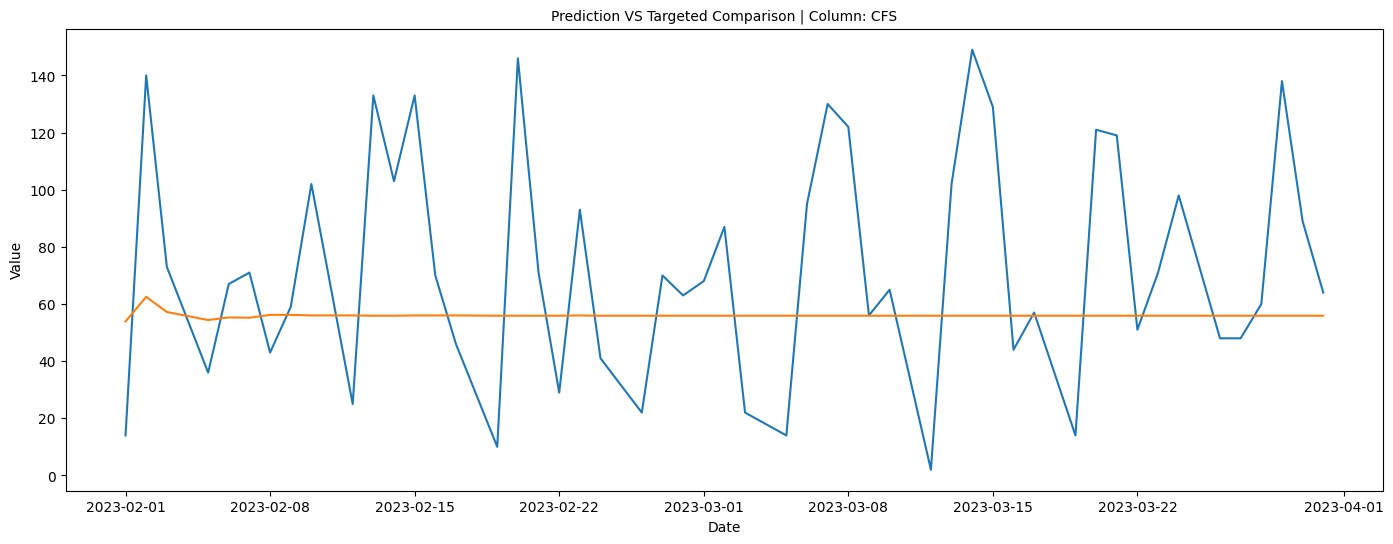

In [88]:
#Plotting
plt.figure(figsize=(17,6))
arima_CFS_plot = sns.lineplot(data=CFS_ARIMA_test, x=CFS_ARIMA_test['date'], y=CFS_ARIMA_test['CFS'])
arima_CFS_plot_1 = sns.lineplot(data=CFS_ARIMA_test, x=CFS_ARIMA_test['date'], y=CFS_ARIMA_test['yhat'])
arima_CFS_plot.set_title("Prediction VS Targeted Comparison | Column: CFS", size=10)
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

###**Evaluating the model:** RMSE and MSE

In [89]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mse(predictions, targets):
  return np.mean((targets - predictions) ** 2)


print('RMSE: ', rmse(CFS_ARIMA_test['yhat'],CFS_ARIMA_test['CFS']))
print('MSE: ', mse(CFS_ARIMA_test['yhat'],CFS_ARIMA_test['CFS']))

RMSE:  43.18297594845342
MSE:  1864.769411764706




---

####**Column:** PBFS


In [90]:
#Fitting the model
arima_model_PBFS = ARIMA(PBFS_ARIMA_train['PBFS'], order=(0,1,1))
arima_model_PBFS = arima_model_PBFS.fit()

In [91]:
#Predicting Values
PBFS_start = len(PBFS_ARIMA_train) #Identifying a Starting Point
PBFS_end = (len(PBFS_ARIMA_train)+len(PBFS_ARIMA_test)-1) #Identifying an Ending Point
arima_PBFS_predict = arima_model_PBFS.predict(start=PBFS_start,
                                            end=PBFS_end,
                                            typ='levels')
PBFS_ARIMA_test['yhat'] = arima_PBFS_predict.values
PBFS_ARIMA_test['yhat'] = np.round(PBFS_ARIMA_test['yhat'],1)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [92]:
PBFS_ARIMA_test.head(20)

,date,PBFS,yhat
651,2023-02-01,50.0,47.3
652,2023-02-02,47.0,47.3
653,2023-02-03,13.0,47.3
654,2023-02-05,0.0,47.3
655,2023-02-06,8.0,47.3
656,2023-02-07,5.0,47.3
657,2023-02-08,0.0,47.3
658,2023-02-09,27.0,47.3
659,2023-02-10,38.0,47.3
660,2023-02-12,7.0,47.3


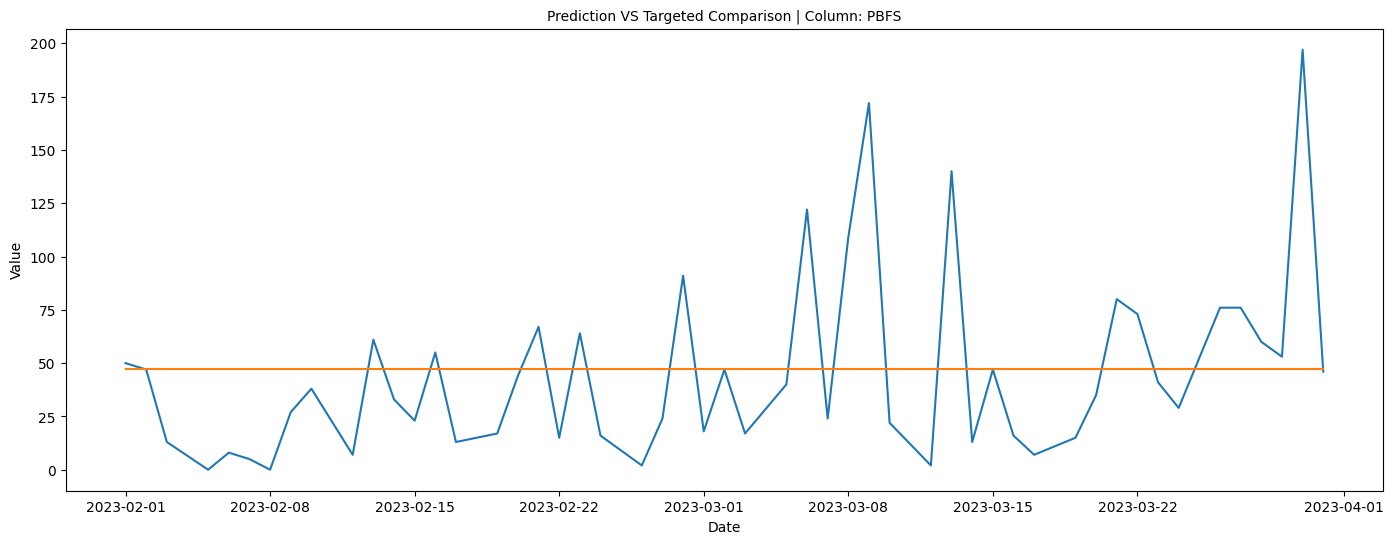

In [93]:
#Plotting
plt.figure(figsize=(17,6))
arima_PBFS_plot = sns.lineplot(data=PBFS_ARIMA_test, x=PBFS_ARIMA_test['date'], y=PBFS_ARIMA_test['PBFS'])
arima_PBFS_plot_1 = sns.lineplot(data=PBFS_ARIMA_test, x=PBFS_ARIMA_test['date'], y=PBFS_ARIMA_test['yhat'])
arima_PBFS_plot.set_title("Prediction VS Targeted Comparison | Column: PBFS", size=10)
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

###**Evaluating the model:** RMSE and MSE

In [94]:
print('RMSE: ', rmse(PBFS_ARIMA_test['yhat'],PBFS_ARIMA_test['PBFS']))
print('MSE: ', mse(PBFS_ARIMA_test['yhat'],PBFS_ARIMA_test['PBFS']))

RMSE:  42.330304816789976
MSE:  1791.8547058823528




---

####**Column:** VFR


In [95]:
#Fitting the model
arima_model_VFR = ARIMA(VFR_ARIMA_train['VFR'], order=(1,0,2))
arima_model_VFR = arima_model_VFR.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [96]:
#Predicting values
VFR_start = len(VFR_ARIMA_train) #Identifying a Starting Point
VFR_end = (len(VFR_ARIMA_train)+len(VFR_ARIMA_test)-1) #Identifying an Ending Point
arima_VFR_predict = arima_model_VFR.predict(start=VFR_start,
                                            end=VFR_end,
                                            typ='levels')
VFR_ARIMA_test['yhat'] = arima_VFR_predict.values
VFR_ARIMA_test['yhat'] = np.round(VFR_ARIMA_test['yhat'],1)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [97]:
VFR_ARIMA_test.head(20)

,date,VFR,yhat
651,2023-02-01,1.0,14.5
652,2023-02-02,15.0,13.5
653,2023-02-03,51.0,13.5
654,2023-02-05,0.0,13.6
655,2023-02-06,1.0,13.7
656,2023-02-07,0.0,13.7
657,2023-02-08,3.0,13.7
658,2023-02-09,8.0,13.8
659,2023-02-10,0.0,13.8
660,2023-02-12,0.0,13.8


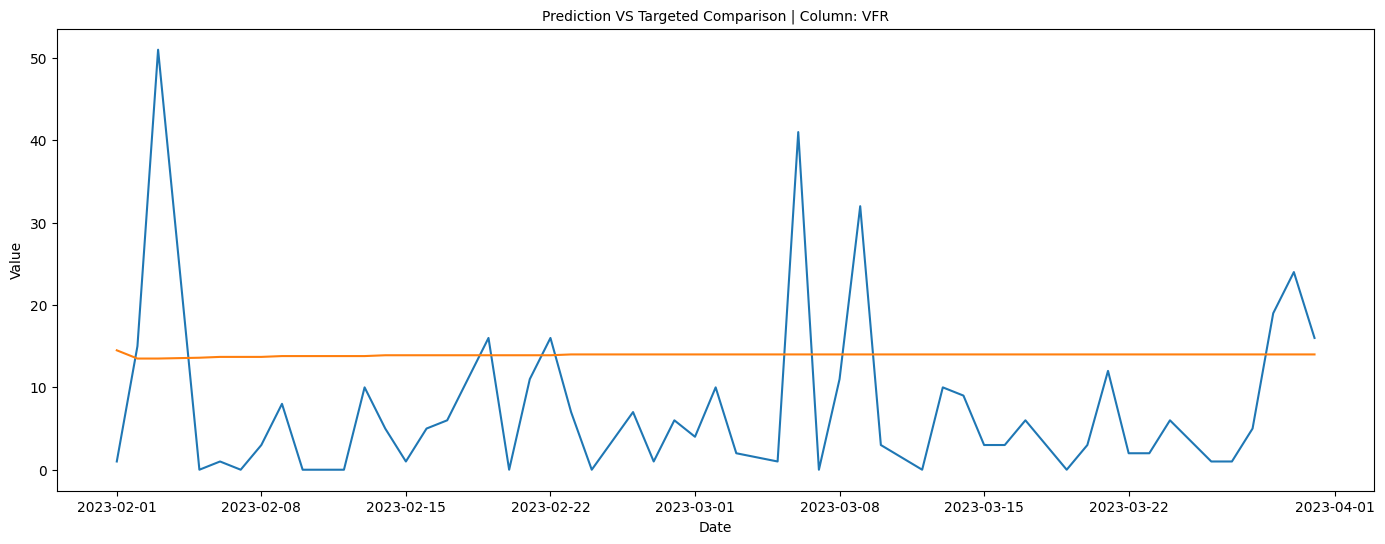

In [98]:
#Plotting
plt.figure(figsize=(17,6))
arima_VFR_plot = sns.lineplot(data=VFR_ARIMA_test, x=VFR_ARIMA_test['date'], y=VFR_ARIMA_test['VFR'])
arima_VFR_plot_1 = sns.lineplot(data=VFR_ARIMA_test, x=VFR_ARIMA_test['date'], y=VFR_ARIMA_test['yhat'])
arima_VFR_plot.set_title("Prediction VS Targeted Comparison | Column: VFR", size=10)
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

###**Evaluating the model:** RMSE and MSE

In [99]:
print('RMSE: ', rmse(VFR_ARIMA_test['yhat'],VFR_ARIMA_test['VFR']))
print('MSE: ', mse(VFR_ARIMA_test['yhat'],VFR_ARIMA_test['VFR']))

RMSE:  12.016997765420347
MSE:  144.40823529411765




---

##**ARIMA Model:** Conclusion

It's showing that the ARIMA model for the 3 independent variables is performing poorly as it predicts starting values yet it provides a static value for the rest of the predictions, This could have various reasons:

- The size of the dataset is a weak point for this model, Making it unable to predict accurate values based on historical data.
- The **AIC** values are not optimal; Inspite of generating the AIC through the `auto_arima` function, It depends mainly on the size of the data and hence, based on the size of the data, It could provide the best fit AIC value.

**In conclusion:** It's clear that the **ARIMA model is underperforming** in this time-series forecasting project, providing only static predictions for the majority of the data. This could be attributed to various factors, including the size of the dataset, which may be limiting the model's ability to accurately predict future values based on historical data. Additionally, while the AIC values generated through the auto_arima function are useful, they may not be optimal for all datasets, particularly in cases where the dataset size is a limiting factor.

However, **it's important to note that the Prophet model is performing better than the ARIMA model in this project** and could be a more suitable choice for this dataset.

---------

#**Random Forest Modeling**

**Random Forest** is a supervised machine learning model that works well with classification and regression data.

It is an ensemble learning method that constructs multiple decision trees and aggregates them for the best performing decision tree model.

In [100]:
#Taking a copy of the 3 dataframes to use in other models (because prophet model requires column names to be changed) (Random Forest)
rf_CFS = data_CFS.copy()
rf_PBFS = data_PBFS.copy()
rf_VFR = data_VFR.copy()

###**Column:** CFS

In [101]:
#Splitting the data
rf_CFS_X_train, rf_CFS_X_test, rf_CFS_y_train, rf_CFS_y_test = train_test_split(rf_CFS.drop('CFS', axis=1),
                                                                                rf_CFS['CFS'],
                                                                                test_size=0.2,
                                                                                random_state=42)

In [102]:
#Fitting the model
rf_model_CFS = RandomForestRegressor(n_estimators=1000,
                                     random_state=42,
                                     max_depth=3)

**learning_rate:** This parameter controls the step size at each iteration of the boosting process. A smaller learning rate can prevent the model from overfitting, but it also requires more iterations to converge.

**max_depth:** This parameter specifies the maximum depth of each tree in the ensemble. A deeper tree can capture more complex patterns in the data, but it can also overfit the training data.

**n_estimators:** This parameter specifies the number of trees (i.e., the number of boosting rounds) in the ensemble. Increasing the number of trees can improve the performance of the model, but it can also make the training process slower.

In [103]:
#Fitting
rf_model_CFS = rf_model_CFS.fit(rf_CFS_X_train, rf_CFS_y_train)
#Predicting
rf_model_CFS_pred = rf_model_CFS.predict(rf_CFS_X_test)

In [104]:
print('RMSE: ', rmse(rf_CFS_y_test, rf_model_CFS_pred))
print('MSE: ', mse(rf_CFS_y_test, rf_model_CFS_pred))

RMSE:  36.906200488462105
MSE:  1362.0676344945605




---


###**Column:** PBFS

In [105]:
#Splitting the data
rf_PBFS_X_train, rf_PBFS_X_test, rf_PBFS_y_train, rf_PBFS_y_test = train_test_split(rf_PBFS.drop('PBFS', axis=1),
                                                                                    rf_PBFS['PBFS'],
                                                                                    test_size=0.2,
                                                                                    random_state=42)

In [106]:
#Fitting the model
rf_model_PBFS = RandomForestRegressor(n_estimators=1000,
                                      random_state=42,
                                      max_depth=3)

In [107]:
#Fitting
rf_model_PBFS = rf_model_PBFS.fit(rf_PBFS_X_train, rf_PBFS_y_train)
#Predicting
rf_model_PBFS_pred = rf_model_PBFS.predict(rf_PBFS_X_test)

In [108]:
print('RMSE: ', rmse(rf_PBFS_y_test, rf_model_PBFS_pred))
print('MSE: ', mse(rf_PBFS_y_test, rf_model_PBFS_pred))

RMSE:  43.35228664361837
MSE:  1879.4207572304517




---


###**Column:** VFR

In [109]:
#Splitting the data
rf_VFR_X_train, rf_VFR_X_test, rf_VFR_y_train, rf_VFR_y_test = train_test_split(rf_VFR.drop('VFR', axis=1),
                                                                                rf_VFR['VFR'],
                                                                                test_size=0.2,
                                                                                random_state=42)

In [110]:
#Fitting the model
rf_model_VFR = RandomForestRegressor(n_estimators=1000,
                                     random_state=42,
                                     max_depth=3)
rf_model_VFR = rf_model_VFR.fit(rf_VFR_X_train, rf_VFR_y_train)
#Predicting
rf_model_VFR_pred = rf_model_VFR.predict(rf_VFR_X_test)

In [111]:
print('RMSE: ', rmse(rf_VFR_y_test, rf_model_VFR_pred))
print('MSE: ', mse(rf_VFR_y_test, rf_model_VFR_pred))

RMSE:  16.960037504505873
MSE:  287.6428721542458




---
#**Models Comparison**


###**Column:** CFS

In [112]:
#Prophet Model | Column: CFS
CFS_Prophet_mse = CFS_metrics['mse'].mean()
CFS_Prophet_rmse = CFS_metrics['rmse'].mean()


#ARIMA Model | Column: CFS
CFS_ARIMA_mse = mse(CFS_ARIMA_test['yhat'],CFS_ARIMA_test['CFS'])
CFS_ARIMA_rmse = rmse(CFS_ARIMA_test['yhat'],CFS_ARIMA_test['CFS'])


#Random Forest Model | Column: CFS
CFS_rf_mse = mse(rf_CFS_y_test, rf_model_CFS_pred)
CFS_rf_rmse = rmse(rf_CFS_y_test, rf_model_CFS_pred)

print(f'Prophet model MSE {np.round(CFS_Prophet_mse,2)}, ARIMA model MSE {np.round(CFS_ARIMA_mse,2)}, Random Forest model MSE {np.round(CFS_rf_mse,2)}')
print(f'Prophet model RMSE {np.round(CFS_Prophet_rmse,2)}, ARIMA model RMSE {np.round(CFS_ARIMA_rmse,2)}, Random Forest model RMSE {np.round(CFS_rf_rmse,2)}')

Prophet model MSE 1699.59, ARIMA model MSE 1864.77, Random Forest model MSE 1362.07
Prophet model RMSE 41.13, ARIMA model RMSE 43.18, Random Forest model RMSE 36.91


###**Column:** PBFS

In [113]:
#Prophet Model | Column: PBFS
PBFS_Prophet_mse = PBFS_metrics['mse'].mean()
PBFS_Prophet_rmse = PBFS_metrics['rmse'].mean()


#ARIMA Model | Column: PBFS
PBFS_ARIMA_mse = mse(PBFS_ARIMA_test['yhat'],PBFS_ARIMA_test['PBFS'])
PBFS_ARIMA_rmse = rmse(PBFS_ARIMA_test['yhat'],PBFS_ARIMA_test['PBFS'])


#Random Forest Model | Column: PBFS
PBFS_rf_mse = mse(rf_PBFS_y_test, rf_model_PBFS_pred)
PBFS_rf_rmse = rmse(rf_PBFS_y_test, rf_model_PBFS_pred)

print(f'Prophet model MSE {np.round(PBFS_Prophet_mse,2)}, ARIMA model MSE {np.round(PBFS_ARIMA_mse,2)}, Random Forest model MSE {np.round(PBFS_rf_mse,2)}')
print(f'Prophet model RMSE {np.round(PBFS_Prophet_rmse,2)}, ARIMA model RMSE {np.round(PBFS_ARIMA_rmse,2)}, Random Forest model RMSE {np.round(PBFS_rf_rmse,2)}')

Prophet model MSE 1749.42, ARIMA model MSE 1791.85, Random Forest model MSE 1879.42
Prophet model RMSE 41.57, ARIMA model RMSE 42.33, Random Forest model RMSE 43.35


###**Column:** VFR

In [114]:
#Prophet Model | Column: VFR
VFR_Prophet_mse = VFR_metrics['mse'].mean()
VFR_Prophet_rmse = VFR_metrics['rmse'].mean()


#ARIMA Model | Column: VFR
VFR_ARIMA_mse = mse(VFR_ARIMA_test['yhat'],VFR_ARIMA_test['VFR'])
VFR_ARIMA_rmse = rmse(VFR_ARIMA_test['yhat'],VFR_ARIMA_test['VFR'])


#Random Forest Model | Column: VFR
VFR_rf_mse = mse(rf_VFR_y_test, rf_model_VFR_pred)
VFR_rf_rmse = rmse(rf_VFR_y_test, rf_model_VFR_pred)

print(f'Prophet model MSE {np.round(VFR_Prophet_mse,2)}, ARIMA model MSE {np.round(VFR_ARIMA_mse,2)}, Random Forest model MSE {np.round(VFR_rf_mse,2)}')
print(f'Prophet model RMSE {np.round(VFR_Prophet_rmse,2)}, ARIMA model RMSE {np.round(VFR_ARIMA_rmse,2)}, Random Forest model RMSE {np.round(VFR_rf_rmse,2)}')

Prophet model MSE 476.55, ARIMA model MSE 144.41, Random Forest model MSE 287.64
Prophet model RMSE 21.57, ARIMA model RMSE 12.02, Random Forest model RMSE 16.96


#**Models Comparison:** Conclusion

- In this project, we compared the performance of three different models - **Prophet**, **ARIMA**, and **Random Forest** - for time series analysis of the **CFS**, **PBFS**, and **VFR** variables. We evaluated the models based on the mean squared error **(MSE)** and root mean squared error **(RMSE)** metrics. **Based on these metrics**, the Random Forest model appeared to perform the best for the CFS and VFR variables, with the **lowest** MSE and RMSE values compared to the other two models. **However**, the performance of the models was relatively similar for the PBFS variable, with small differences in the MSE and RMSE values between the models.

- It is important to note that the susceptibility to **overfitting** can vary depending on the dataset, **but in general**, Random Forest models are **more** susceptible to overfitting compared to Prophet and ARIMA models.

- Therefore, It would be safe to conclude that the **Prophet Model** seems to be the best option in this case because the difference in performance with **Random Forest Model** is very slight and it's not subjected to **Overfitting** in comparison with **Random Forest Model**